In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pyramid as pm
from sklearn import metrics

# make notebook behave like interactive Python shell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [9]:
df = sns.load_dataset('flights')
df.head()
df.tail()
df.shape
df.describe()
df.info()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


,year,month,passengers
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390
143,1960,Dec,432


(144, 3)

,year,passengers
count,144.000000,144.000000
mean,1954.500000,280.298611
std,3.464102,119.966317
min,1949.000000,104.000000
25%,1951.750000,180.000000
50%,1954.500000,265.500000
75%,1957.250000,360.500000
max,1960.000000,622.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [10]:
flight_pivot = df.pivot('month', 'year', 'passengers')
flight_pivot

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
Jun,135,149,178,218,243,264,315,374,422,435,472,535
Jul,148,170,199,230,264,302,364,413,465,491,548,622
Aug,148,170,199,242,272,293,347,405,467,505,559,606
Sep,136,158,184,209,237,259,312,355,404,404,463,508


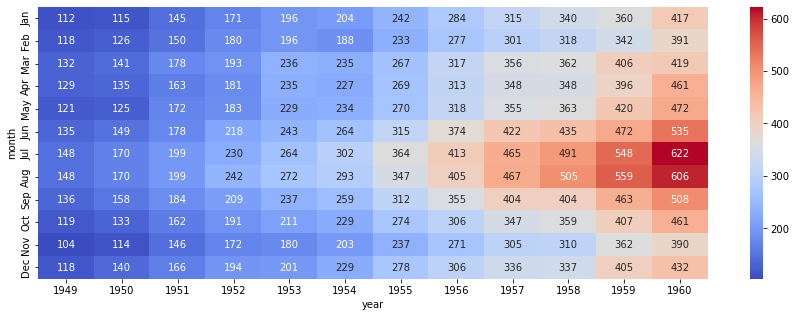

In [34]:
plt.figure(figsize=(15, 5))
sns.heatmap(flight_pivot, annot=True, fmt='d', cmap='coolwarm')
plt.show();

In [18]:
month = pd.date_range('19490131', periods=144, freq='M')
month

DatetimeIndex(['1949-01-31', '1949-02-28', '1949-03-31', '1949-04-30',
               '1949-05-31', '1949-06-30', '1949-07-31', '1949-08-31',
               '1949-09-30', '1949-10-31',
               ...
               '1960-03-31', '1960-04-30', '1960-05-31', '1960-06-30',
               '1960-07-31', '1960-08-31', '1960-09-30', '1960-10-31',
               '1960-11-30', '1960-12-31'],
              dtype='datetime64[ns]', length=144, freq='M')

In [28]:
df.loc[:, 'datestamp'] = month
df.head()

/Users/home/bin/anaconda3/envs/py38/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,year,month,passengers,datestamp
0,1949,Jan,112,1949-01-31
1,1949,Feb,118,1949-02-28
2,1949,Mar,132,1949-03-31
3,1949,Apr,129,1949-04-30
4,1949,May,121,1949-05-31


In [30]:
data = df.loc[:, ('datestamp', 'passengers')]
data.head()
data.describe()

,datestamp,passengers
0,1949-01-31,112
1,1949-02-28,118
2,1949-03-31,132
3,1949-04-30,129
4,1949-05-31,121


,passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [31]:
data.set_index('datestamp', inplace=True)
data.head()

,passengers
datestamp,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


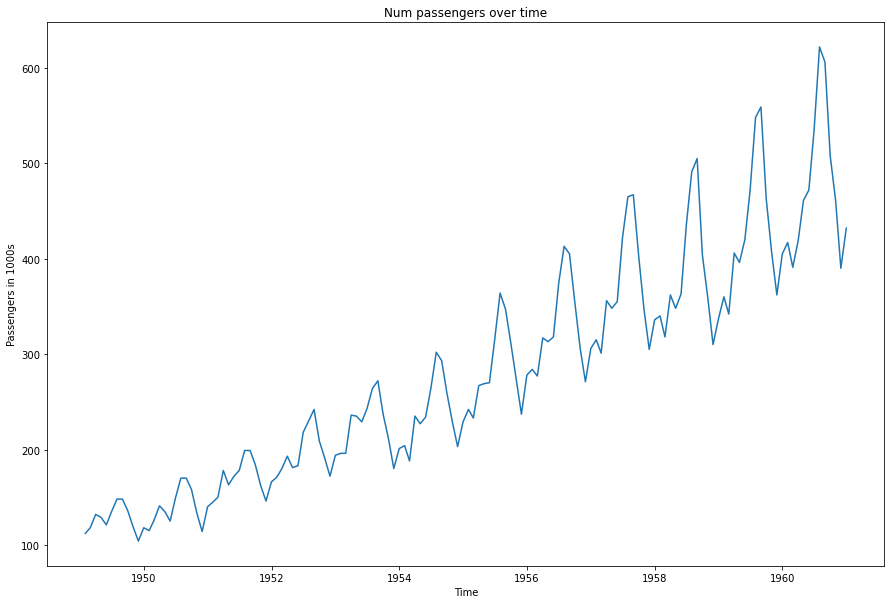

In [33]:
plt.figure(figsize=(15, 10))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Passengers in 1000s')
plt.title('Num passengers over time')
plt.show();

Decompose timeseries to trend, seasonal, and random components using multiplicative model.

In [35]:
decomposition = seasonal_decompose(data, model='multiplicative')

In [43]:
def plot_decomp():
    plt.figure(figsize=(20, 10))

    plt.subplot(221)
    plt.plot(data, color='black', label='orignal')
    plt.legend(loc='best')

    plt.subplot(222)
    plt.plot(decomposition.trend, 'b', label='Trend')
    plt.legend(loc='best')

    plt.subplot(223)
    plt.plot(decomposition.seasonal, color='green', label='seasonality')
    plt.legend(loc='best')

    plt.subplot(224)
    plt.plot(decomposition.resid, 'orange', label='Residuals')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show();

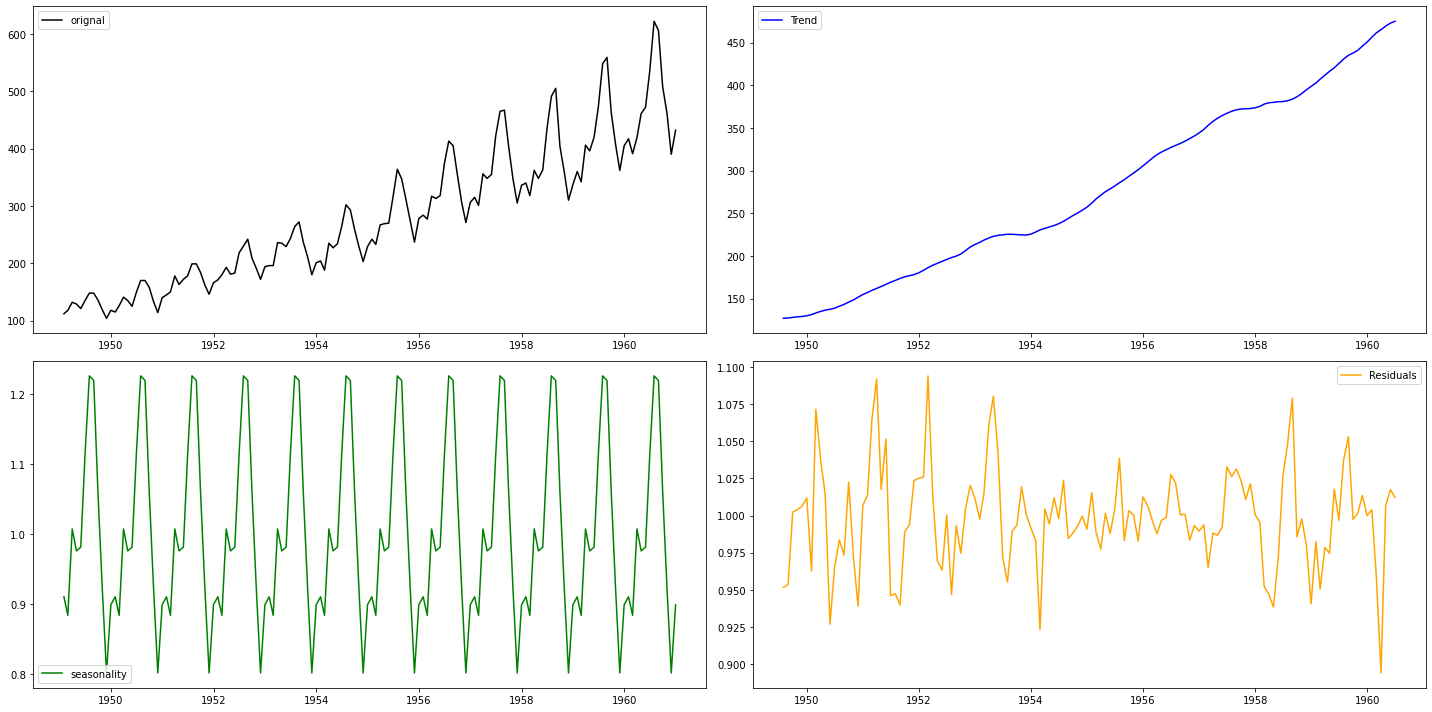

In [44]:
plot_decomp()

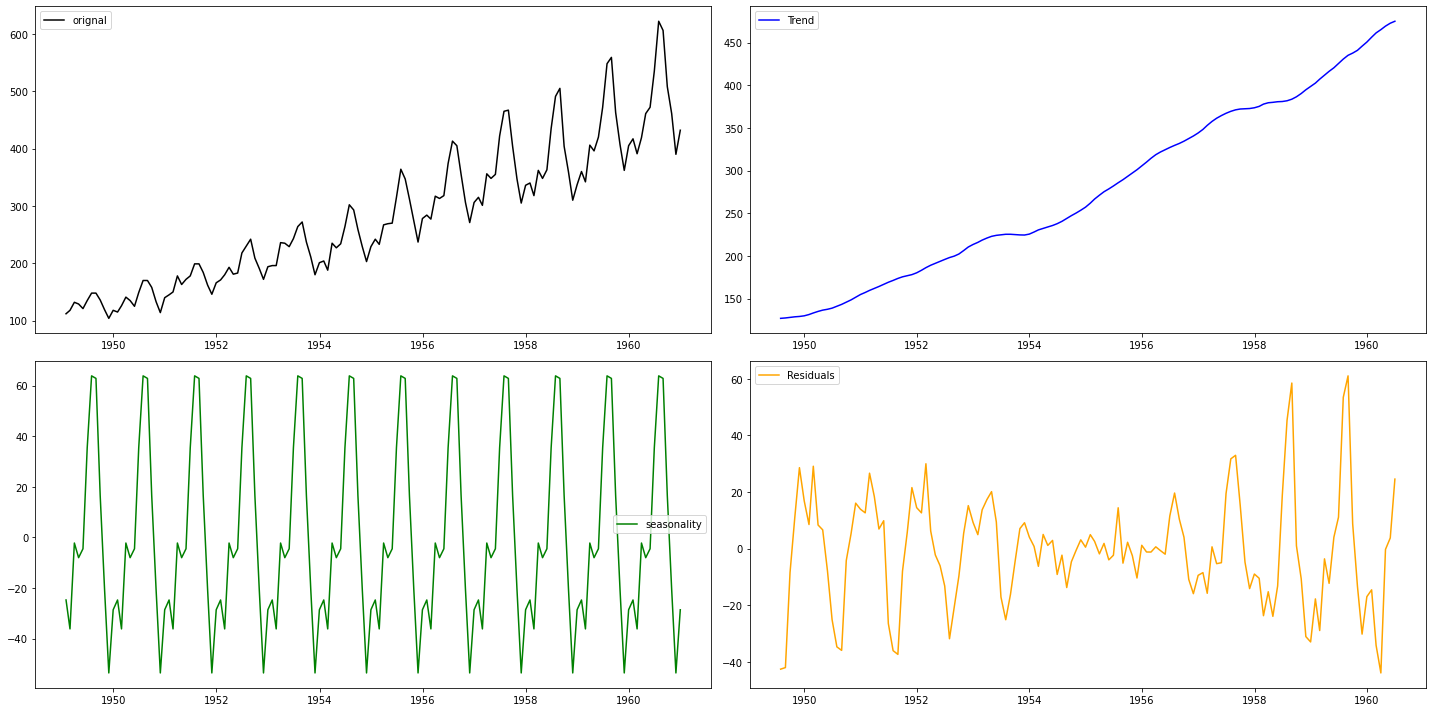

In [45]:
decomposition = seasonal_decompose(data, model='additive')
plot_decomp()

In [52]:
# https://github.com/alkaline-ml/pmdarima
from pmdarima.arima.stationarity import ADFTest

test = ADFTest(alpha=0.05)
test.should_diff(data)

(0.01, False)

In [53]:
train, test = data[:100], data[100:]
train.shape, test.shape

((100, 1), (44, 1))

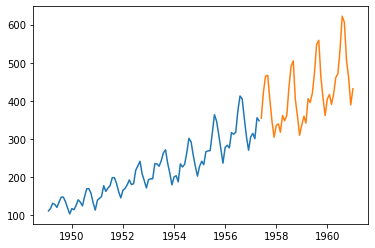

In [54]:
plt.plot(train)
plt.plot(test)
plt.show();

Now is the time that we can fit a Auto ARIMA model, which works on the efficient Grid Search and Random Search concepts to find the most optimal parameters to find the best fitting time series model. Please keep in mind that small p,d,q represent the non-seasonal components and capital P,D,Q represent seasonal components.

In this case, we are trying values from 1 to 8 for each of the above parameters in the efficient parameters search. 

In [68]:
import warnings
warnings.filterwarnings('ignore')
from pmdarima import auto_arima

model = auto_arima(train, start_p=1, start_q=1, max_p=8, max_q=8, start_P=0, start_Q=0, max_P=8,
                   max_Q=8, m=12, seasonal=True, trace=True, d=1, D=1, error_action='warn', suppress_warnings=True,
                   stepwise=True, random_state=20, n_fits=30)
                   
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=647.341, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=650.796, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=644.203, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=644.733, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=645.995, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=646.172, Time=0.15 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=646.187, Time=0.13 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=644.600, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=647.442, Time=0.04 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=646.085, Time=0.09 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=645.647, Time=0.11 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=644.346, Time=0.06 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=647.580, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -319.101
Date:                            Thu, 04 Nov 2021   AIC                            644.203
Time:                                    16:39:59   BIC                            651.601
Sample:                                         0   HQIC                           647.182
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2434      0.097     -2.512      0.012      -0.433      -0.054
ar.S.L12      -0.2127      0.087     -2.432      0.015      -0.384      -0.041
sigma2        89.1842     14.080      6.334      0.000      61.587     116.781
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.97   Prob(JB):                         0.30
Heteroskedasticity (H):               1.32   Skew:                             0.40
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
prediction = pd.DataFrame(model.predict(n_periods=44), index=test.index, columns=['Predicted_Passengers'])
prediction.head()

,Predicted_Passengers
datestamp,
1957-05-31,353.433649
1957-06-30,406.781321
1957-07-31,447.984392
1957-08-31,438.051605
1957-09-30,391.246543


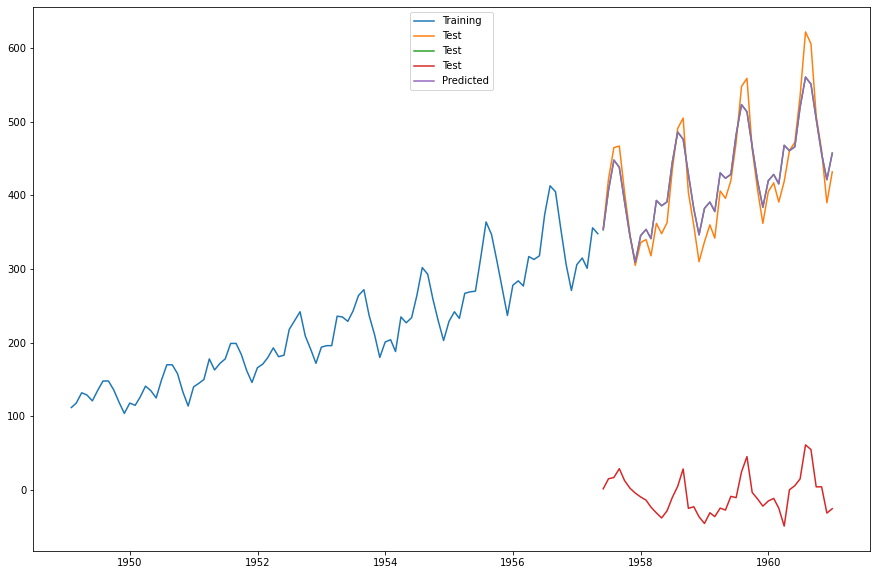

In [70]:
plt.figure(figsize=(15, 10))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(prediction, label='Predicted')
plt.legend(loc='upper center')
plt.show();

In [71]:
test['Predicted_Passengers'] = prediction
test['Error'] = test['passengers'] - test['Predicted_Passengers']
test.head()

,passengers,Predicted_Passengers,Error
datestamp,,,
1957-05-31,355,353.433649,1.566351
1957-06-30,422,406.781321,15.218679
1957-07-31,465,447.984392,17.015608
1957-08-31,467,438.051605,28.948395
1957-09-30,404,391.246543,12.753457


In [72]:
for m in (metrics.mean_absolute_error, metrics.mean_squared_error, metrics.median_absolute_error):
    print(m(test.passengers, test.Predicted_Passengers))

21.538631282392426
686.7476359637593
22.334088545629015


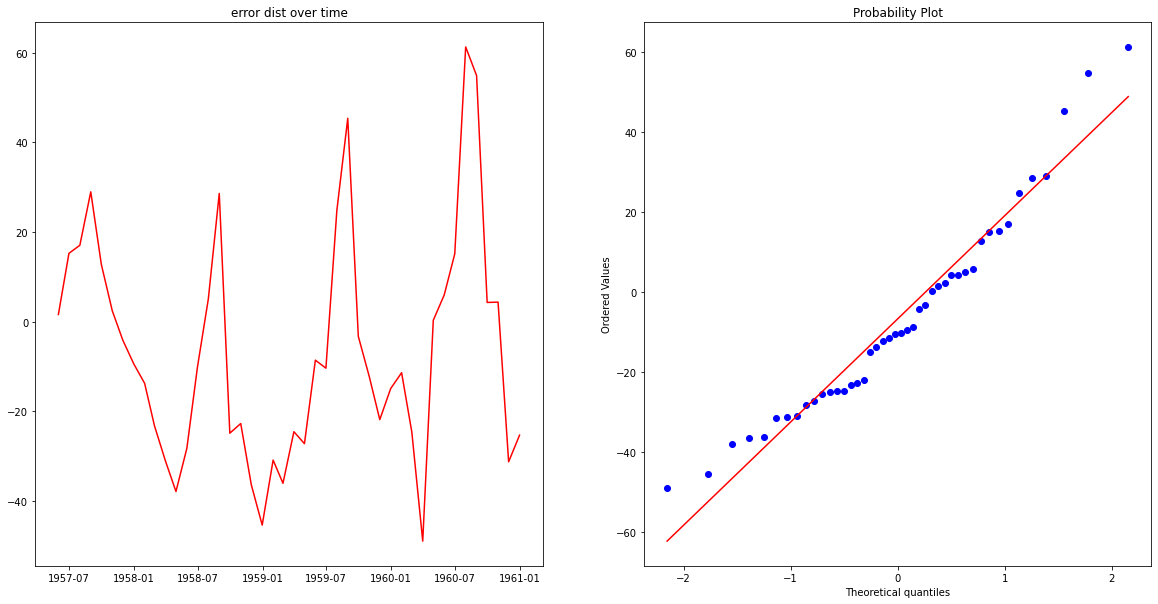

In [74]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(test.Error, color='red')
plt.title('error dist over time')
plt.subplot(122)
scipy.stats.probplot(test.Error, plot=plt)
plt.show();

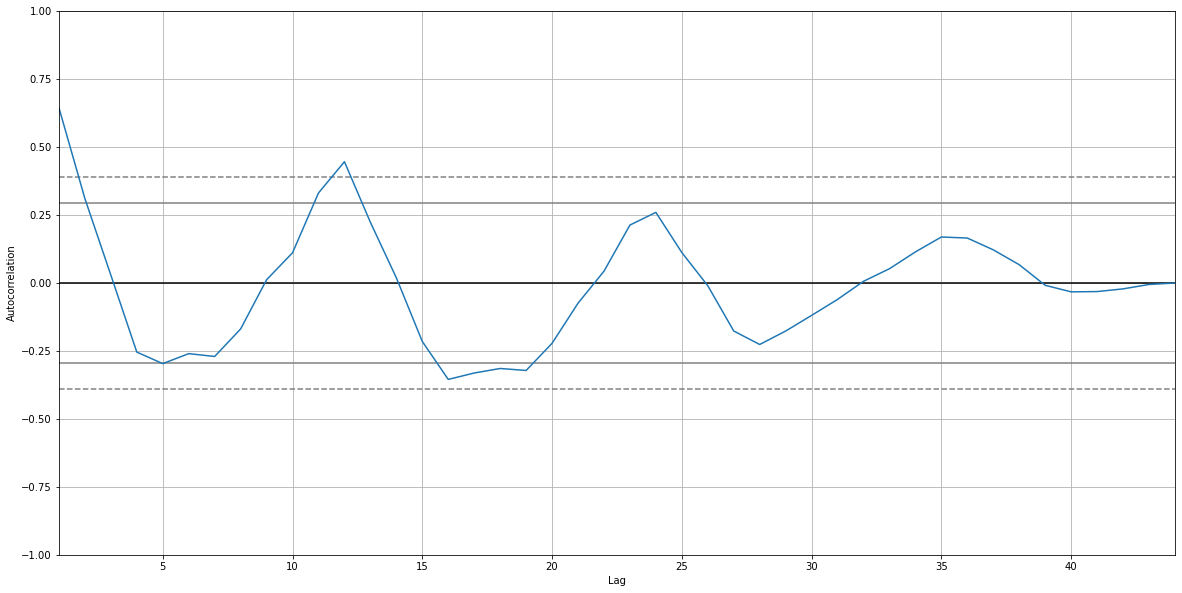

In [77]:
from pmdarima.utils import autocorr_plot

plt.figure(figsize=(20, 10))
autocorr_plot(test.Error)
plt.show();